In [2]:
import math
import point_similarity as ps
import scipy.integrate as integrate
import pylab
import mpmath
from scipy.misc import derivative
import plotly
from plotly import graph_objs as go
import sys
import read_arbor_reconstruction as rar
import networkx as nx
import pareto_functions as pf

In [287]:
arbor = 'skjlkds.csv'
path = 'test/test/blah'
fname = '%s/%s' % (path, arbor)
fname

'test/test/blah/skjlkds.csv'

In [3]:
def calc_coeff(G, x, y, p, q):
    b = ((q - y - G*(p*p - x*x))/(p-x))
    c = (q - G*p*p - b*p)

    # assert (G * x * x) + (b * x) + c == y
    # assert (G * p * p) + (b * p) + c == q
    
    return b, c

In [101]:
calc_coeff(0, 4, 7.5, 7, 2)

(-1.8333333333333333, 14.833333333333332)

In [4]:
def curve_length(G, x0, y0, p, q):        
    b, c = calc_coeff(G, x0, y0, p, q)
    def differential(x):
        return pylab.sqrt(1 + (2*G*x + b)**2)
    curve, tolerance = integrate.quad(differential, min(x0, p), max(x0, p))
    return curve

In [103]:
curve_length(0, 3.8, 7.4, 7, 2)

6.276941930590086

In [5]:
def distance_from_base(root_distance, x, y, x1, y1):
    pair1 = [x, y]
    pair2 = [x1, y1]
    distance = math.dist(pair1, pair2)
    if(x,y) == (x1, y1):
        assert distance == 0
    return distance + root_distance

In [105]:
distance_from_base(100, 3, 7, 3.8, 7.4)

100.89442719099992

In [24]:
def total_cost(seg_length, alpha, G, root_distance, x0, y0, x1, y1, p, q):
    if G == 0:
        edge = length_func(x1, y1, p, q)
    else:
        edge = curve_length(G, x1, y1, p, q)
        
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = edge
    delay = (edge + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
    #cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost, wiring, delay

In [298]:
total_cost(0.3, 0, 0, 3, 7, 8, 7, 7, 2)

(8.599019513592784, 5.0990195135927845, 10.099019513592784)

In [6]:
def length_func(x0, y0, x1, y1):
    length = pylab.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    return length

In [7]:
def get_theta(x0, y0, x1, y1):
    theta = pylab.arctan((abs(y1 - y0))/(abs(x1 - x0)))
    return theta

In [8]:
def positive_slope(x0, y0, x1, y1):
    slope = (y1 - y0)/(x1 - x0)
    if slope >= 0:
        return True
    return False

In [9]:
def find_best_cost(root_length, alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    best_wiring = math.inf
    best_delay = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        is_positive = positive_slope(x0, y0, x1, y1)
        new_x = None
        new_y = None
        if is_positive:
            new_x = x0 + t*l*math.cos(theta)
            new_y = y0 + t*l*math.sin(theta)
        else: 
            new_x = x0 - (t*l*math.cos(theta))
            new_y = y0 + (t*l*math.sin(theta))
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost, wiring, delay = total_cost(l, alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost <= best_cost:
            best_cost = cost
            best_wiring = wiring
            best_delay = delay
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           ''' 
        results.append(cost)
    ##opt_line = go.Scatter(x = x_opt, y = y_opt, mode = "lines", name = "Optimal: " + str(best_cost))
    ##fig.add_trace(opt_line)
    return best_cost, best_wiring, best_delay, best_t, best_x, best_y, p, q

In [112]:
'''
pt1 = [5, 0.1]
pt2 = [-13, 2]

p_pt = 7
q_pt = 2
G = 0
alpha = 0.5
Droot = 0
main = go.Scatter(x=pt1, y=pt2, name="main root segment")
pq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")

example_fig = go.Figure()
example_fig.add_trace(main)
example_fig.add_trace(pq)

find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)
example_fig.update_layout(xaxis_range=[2.5, 6.5])
example_fig.update_layout(yaxis_range=[5.5, 8.5])
example_fig.show()
'''

'\npt1 = [5, 0.1]\npt2 = [-13, 2]\n\np_pt = 7\nq_pt = 2\nG = 0\nalpha = 0.5\nDroot = 0\nmain = go.Scatter(x=pt1, y=pt2, name="main root segment")\npq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")\n\nexample_fig = go.Figure()\nexample_fig.add_trace(main)\nexample_fig.add_trace(pq)\n\nfind_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)\nexample_fig.update_layout(xaxis_range=[2.5, 6.5])\nexample_fig.update_layout(yaxis_range=[5.5, 8.5])\nexample_fig.show()\n'

In [10]:
def get_length_and_theta(x0, y0, x1, y1):
    length = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    return length, theta

In [11]:
def three_line_segments(alpha, G, root_distance, x0, y0, x1, y1, x2, y2, x3, y3, p, q):
    min_t = 0
    delta = 0.01
    max_t = 1
    
    s1 = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
    
    segment1_length = length_func(x0, y0, x1, y1)
    s2 = find_best_cost(alpha, G, root_distance + segment1_length, x1, y1, x2, y2, p, q)

    segment2_length = length_func(x1, y1, x2, y2)
    s3 = find_best_cost(alpha, G, root_distance + segment1_length + segment2_length, x2, y2, x3, y3, p, q)
    print(s1)
    print(s2)
    print(s3)
    
    
    return min(s1[0], s2[0], s3[0])

In [119]:
three_line_segments(1, 0, 10, 0, 0, 0.1, 6, 0.3, 13, 0.2, 19, 2, 10)

(4.428317965096906, 1.0, 0.09999999999999934, 6.0, 2, 10)
(1.7850086834522678, 0.58, 0.21600000000000036, 10.06, 2, 10)
(3.448187929913334, 0.0, 0.3, 13.0, 2, 10)


1.7850086834522678

In [12]:
def get_xy_coords(t, x0, y0, x1, y1):
    x = x0 + t * get_length_and_theta(x0, y0, x1, y1)[0] * math.cos(get_length_and_theta(x0, y0, x1, y1)[1])
    y = y0 + t * get_length_and_theta(x0, y0, x1, y1)[0] * math.sin(get_length_and_theta(x0, y0, x1, y1)[1])
    return x, y

In [122]:
get_xy_coords(1, 0.1, 6, 0.3, 13)

(0.30000000000000066, 13.0)

In [353]:
find_best_cost(1, 0, 10, 0.1, 6, 0.3, 13, 2, 10)

7.002856560004639


(1.7850086834522678,
 1.7850086834522678,
 15.84666548825496,
 0.58,
 0.21600000000000036,
 10.06,
 2,
 10)

In [13]:
pt1 = [0, 0.1]
pt2 = [0, 6]

pt3 = [0.1, 0.3]
pt4 = [6, 13]

pt5 = [0.3, 0.2]
pt6 = [13, 19]
p_pt = 2
q_pt = 10
G = 0
alpha = 1
Droot = 10

s1_t = find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)[1]
s1_opt = get_xy_coords(s1_t, pt1[0], pt2[0], pt1[1], pt2[1])

s2_t = find_best_cost(alpha, G, Droot, pt1[1], pt2[1], pt3[1], pt4[1], p_pt, q_pt)[1]
s2_opt = get_xy_coords(s2_t, pt1[1], pt2[1], pt3[1], pt4[1])

s3_t = find_best_cost(alpha, G, Droot, pt3[1], pt4[1], pt5[1], pt6[1], p_pt, q_pt)[1]
s3_opt = get_xy_coords(s3_t, pt3[1], pt4[1], pt5[1], pt6[1])

segment1 = go.Scatter(x=pt1, y=pt2, name="main root segment1")
segment2 = go.Scatter(x=pt3, y=pt4, name="main root segment2")
segment3 = go.Scatter(x=pt5, y=pt6, name="main root segment3")

pq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")

s1_pt = go.Scatter(x = [s1_opt[0]], y = [s1_opt[1]], name = "segment1 optimal point")
s2_pt = go.Scatter(x = [s2_opt[0]], y = [s2_opt[1]], name = "segment2 optimal point")
s3_pt = go.Scatter(x = [s3_opt[0]], y = [s3_opt[1]], name = "segment3 optimal point")

s1_pq_x = [s1_opt[0], p_pt]
s1_pq_y = [s1_opt[1], q_pt]

s1_pq = go.Scatter(x=s1_pq_x, y=s1_pq_y, name="PQ - optimal s1 point")

s2_pq_x = [s2_opt[0], p_pt]
s2_pq_y = [s2_opt[1], q_pt]

s2_pq = go.Scatter(x=s2_pq_x, y=s2_pq_y, name="PQ - optimal s2 point")


s3_pq_x = [s3_opt[0], p_pt]
s3_pq_y = [s3_opt[1], q_pt]

s3_pq = go.Scatter(x=s3_pq_x, y=s3_pq_y, name="PQ - optimal s3 point")

example_fig = go.Figure()
example_fig.add_trace(segment1)
example_fig.add_trace(segment2)
example_fig.add_trace(segment3)
example_fig.add_trace(pq)
example_fig.add_trace(s1_pt)
example_fig.add_trace(s2_pt)
example_fig.add_trace(s3_pt)
example_fig.add_trace(s1_pq)
example_fig.add_trace(s2_pq)
example_fig.add_trace(s3_pq)
# find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt, example_fig)
#three_line_segments(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], pt3[1], pt4[1], pt5[1], pt6[1], p_pt, q_pt)
example_fig.show()

TypeError: find_best_cost() missing 1 required positional argument: 'q'

In [14]:
test_figure = go.Figure()

In [15]:
def arbor_best_cost(root_length, fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]
        
    # for each lateral root tip iterate through every line segment to find lowest costing point on main root
    final = []
    for tip in lat_tips:
        curr_dist = 0
        results = []
        firstTime = True
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            main_root_length = 0
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1] 
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            main_root_length += length_func(x0, y0, x1, y1)
            if firstTime == True:
                result = find_best_cost(root_length, alpha, G, root_distance, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
                firstTime = False
            else: 
                result = find_best_cost(root_length, alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
            results.append(result)
        final.append(min(results))
    
    pq_drawings = get_tip_drawings(lat_tips)
    for p_and_q in pq_drawings:
        point_drawing.add_trace(p_and_q)
    
    segment_drawings = get_line_segment_drawings(line_segments)
    for line in segment_drawings:
        point_drawing.add_trace(line)

    opt_lines = get_opt_to_pq_drawings(G, final)
    for opt in opt_lines:
        point_drawing.add_trace(opt)
    point_drawing.show()
    
    return final

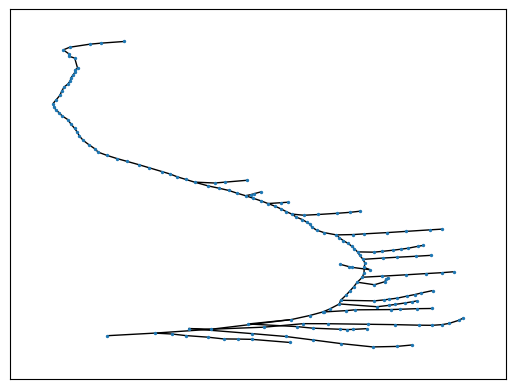

In [40]:
coords = {}
for coordinate in list(G_tas.nodes):
    coords[coordinate] = coordinate
nx.draw_networkx(G_tas, pos = coords, with_labels = False, node_size = 2)

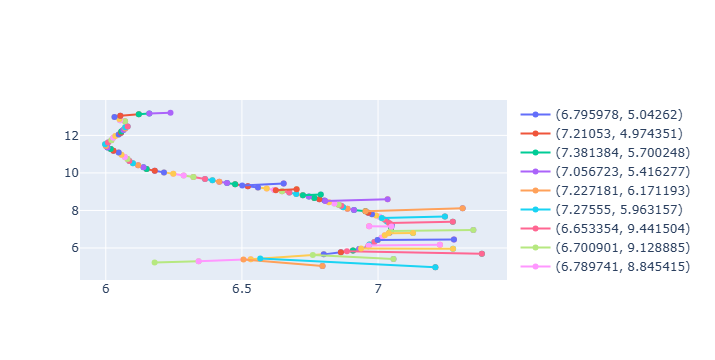

[(0.5230455585755234,
  0.4501348171296663,
  0.8146885243589521,
  0.86,
  6.5056308,
  5.38636664,
  6.795978,
  5.04262),
 (0.8836909755601231,
  0.794950984506113,
  1.2386509397761634,
  0.13,
  6.56729982,
  5.43492144,
  7.21053,
  4.974351),
 (0.7028092238489295,
  0.5129522646504375,
  1.4622370606428978,
  0.5,
  6.885711499999999,
  5.82021,
  7.381384,
  5.700248),
 (0.5035471600431631,
  0.3610677567742744,
  1.0734647731187184,
  0.85,
  6.7603419,
  5.621824800000001,
  7.056723,
  5.416277),
 (0.519145132179337,
  0.265048611988213,
  1.5355312129438334,
  0.43,
  6.965921649999999,
  6.12933384,
  7.227181,
  6.171193),
 (0.5618233671288276,
  0.33916850703360524,
  1.4524428075097173,
  0.2,
  6.937623,
  5.9752752000000005,
  7.27555,
  5.963157),
 (1.100858562543487,
  0.18705563854913923,
  4.75607025852088,
  0.44,
  6.50125536,
  9.33270636,
  6.653354,
  9.441504),
 (0.9492788214453285,
  0.09236889643555349,
  4.37691852148443,
  0.81,
  6.624452010000001,
  9.

In [39]:
G_tas = rar.read_arbor_full("008_2_C_day3.csv")
d_tas = pf.get_root_distances(G_tas)
last_key, root_length = list(d_tas.items())[-1]
tas_results = arbor_best_cost(root_length, "008_2_C_day3.csv", 0.8, 0.4, 0)
tas_results

In [16]:
def get_line_segment_drawings(line_segments):
    segment_drawings = []
    for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]

        xpoints = [x0, x1]
        ypoints = [y0, y1]

        segment = go.Scatter(x= xpoints, y=ypoints, name="segment")
        segment_drawings.append(segment)
    return segment_drawings

In [17]:
def get_tip_drawings(lat_tips):
    pq_drawings = []
    for tip in lat_tips:
        p = tip[0]
        q = tip[1]
        pq = go.Scatter(x = [p], y= [q], name= str(tip))
        pq_drawings.append(pq)
    return pq_drawings

In [251]:
dist1 = length_func(6.316246, 4.788182, 6.248517, 5.230901)
print(find_best_cost(0.5, 0, dist1, 6.248517, 5.230901, 6.172466, 5.448168, 8.047481, 5.966049))
le, the = get_length_and_theta(6.248517, 5.230901, 6.172466, 5.448168)
le, the
supposed_x = 6.248517 + (1 * le * math.cos(the))
supposed_y = 5.230901 + 1 * (le * math.sin(the))
supposed_x, supposed_y, the
get_theta(6.248517, 5.230901, 6.172466, 5.448168)
supposed_x, supposed_y
total_cost(0.5, 0, dist1, 6.248517, 5.230901, 6.172466, 5.448168, 8.934018, 7.703327)
find_best_cost(0, 0, 0, 5.644983, 6.913284, 5.611528, 6.990774, 5.711468, 5.857034)

(2.1673118567075633, 1.9433769719742997, 2.3912467414408267, 0.0, 6.248517, 5.230901, 8.047481, 5.966049)


(1.0583403600567263,
 1.0583403600567263,
 1.0583403600567263,
 0.0,
 5.644983,
 6.913284,
 5.711468,
 5.857034)

In [177]:
for result in results:
    b, c = calc_coeff(0, result[2], result[3], result[4], result[5])
    xcoords = []
    

NameError: name 'results' is not defined

In [377]:
arbor_best_cost('002_1_c_day4.csv', 0, 0, 0)

TypeError: arbor_best_cost() missing 1 required positional argument: 'root_distance'

In [18]:
# if i understand correctly, based on alpha and Gravity constant, code above will return a point (many) that optimizes cost for a lateral root tip
# my task is to use this point to create a line (or curve) from that point to the lateral root tip and then conduct point similarity analysis

# for fill_lateral_root, need to know whether or not G is 0, that way we can properly fill in the optimal line by determining whether it's straight or curved
# need to understand what the graph attributes are for 
# need to make gravity and b, c graph attributes
# also will need to manually write code to draw nodes and edges since plotly and networkx only use straight lines
def calc_pareto_front(fname):
    G = rar.read_arbor_full(fname)
    d = pf.get_root_distances(G)
    last_key, root_length = list(d.items())[-1]
    delta = 0.01
    epsilon = 0.1
    min_alpha = 0.0
    max_alpha = 0.10
    min_gravity = 0
    max_gravity = 0.1
    values = []
    for alpha in pylab.arange(min_alpha, max_alpha + delta, delta):
        for g in pylab.arange(min_gravity, max_gravity + epsilon, epsilon):
            G_opt = nx.Graph(Gravity = g)
            line_segs = get_line_segments(G)
            graph_main_root(G_opt, line_segs)
            final = arbor_best_cost(root_length, fname, alpha, g, 0) # 0 is the root distance but I figured it doesn't matter as code calculates proper root distance
            graph_opt_lines(G_opt, final)
            point_dist = 0
            print("Calculating distances for alpha: " + str(alpha) + " and G = " + str(g))
            wiring = 0
            delay = 0
            cost = 0
            for result in final:
                cost += result[0]
                wiring += result[1]
                delay += result[2]
                main_root = result[4], result[5]
                lateral_tip = result[6], result[7]
                point_dist += modified_calculate_distance(g, G, G_opt, main_root, lateral_tip)
            wiring += main_root_distance(line_segs) # earlier, did not account for the main root when calculating wiring cost
            values.append((cost, alpha, g, wiring, delay, point_dist))
            
    return values

In [387]:
testingout = rar.read_arbor_full('002_1_c_day4.csv')
d = pf.get_root_distances(testingout)
last_key, last_value = list(d.items())[-1]
last_value
arbor_best_cost(last_value, '002_1_c_day4.csv', 0, 0, 0)

[(3.918009777298801,
  3.918009777298801,
  3.918009777298801,
  0.0,
  6.316246,
  4.788182,
  8.934018,
  7.703327),
 (2.637712213530695,
  2.637712213530695,
  2.637712213530695,
  0.0,
  6.316246,
  4.788182,
  8.484618,
  6.290077),
 (2.7645770957670903,
  2.7645770957670903,
  2.7645770957670903,
  0.0,
  6.316246,
  4.788182,
  8.50546,
  6.476444),
 (2.0939305850275933,
  2.0939305850275933,
  2.0939305850275933,
  0.0,
  6.316246,
  4.788182,
  8.047481,
  5.966049),
 (3.258760787424877,
  3.258760787424877,
  3.258760787424877,
  0.0,
  6.316246,
  4.788182,
  7.725423,
  7.726505),
 (3.011397304532565,
  3.011397304532565,
  3.011397304532565,
  0.0,
  6.316246,
  4.788182,
  4.119307,
  6.847787),
 (2.074728732088607,
  2.074728732088607,
  2.074728732088607,
  0.0,
  6.316246,
  4.788182,
  4.741723,
  6.139247),
 (1.5444593641870281,
  1.5444593641870281,
  1.5444593641870281,
  0.0,
  6.316246,
  4.788182,
  6.692531,
  6.286102),
 (1.3379718925093307,
  1.33797189250933

In [390]:
calc_pareto_front('002_1_c_day4.csv')

Calculating distances for alpha: 0.0 and G = 0.0
Calculating distances for alpha: 0.0 and G = 0.1
Calculating distances for alpha: 0.01 and G = 0.0
Calculating distances for alpha: 0.01 and G = 0.1
Calculating distances for alpha: 0.02 and G = 0.0
Calculating distances for alpha: 0.02 and G = 0.1
Calculating distances for alpha: 0.03 and G = 0.0
Calculating distances for alpha: 0.03 and G = 0.1
Calculating distances for alpha: 0.04 and G = 0.0
Calculating distances for alpha: 0.04 and G = 0.1
Calculating distances for alpha: 0.05 and G = 0.0
Calculating distances for alpha: 0.05 and G = 0.1
Calculating distances for alpha: 0.06 and G = 0.0
Calculating distances for alpha: 0.06 and G = 0.1
Calculating distances for alpha: 0.07 and G = 0.0
Calculating distances for alpha: 0.07 and G = 0.1
Calculating distances for alpha: 0.08 and G = 0.0
Calculating distances for alpha: 0.08 and G = 0.1
Calculating distances for alpha: 0.09 and G = 0.0
Calculating distances for alpha: 0.09 and G = 0.1
Ca

[(26.57070340818152,
  0.0,
  0.0,
  29.44270132437781,
  26.57070340818152,
  106.07722956983068),
 (26.6146403047349,
  0.0,
  0.1,
  29.48663822093119,
  26.6146403047349,
  100.8102481240575),
 (26.57070340818152,
  0.01,
  0.0,
  29.44270132437781,
  26.57070340818152,
  106.07722956983068),
 (26.6146403047349,
  0.01,
  0.1,
  29.48663822093119,
  26.6146403047349,
  100.8102481240575),
 (26.57070340818152,
  0.02,
  0.0,
  29.44270132437781,
  26.57070340818152,
  106.07722956983068),
 (26.6146403047349,
  0.02,
  0.1,
  29.48663822093119,
  26.6146403047349,
  100.8102481240575),
 (26.570517308186925,
  0.03,
  0.0,
  29.34693981557906,
  26.573473248665405,
  85.61854084245536),
 (26.61445420688514,
  0.03,
  0.1,
  29.390876714277276,
  26.617410147363618,
  80.39903669130736),
 (26.568420840698373,
  0.04,
  0.0,
  29.148049371386914,
  26.580602898427863,
  61.75044963181284),
 (26.61235775470019,
  0.04,
  0.1,
  29.19198628538874,
  26.624539812429685,
  56.59793186132253

In [33]:
def modified_calculate_distance(gravity, G, G_opt, main_root, lateral_tip):
    opt_y_coords, actual_y_coords = modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip)
    distances = []
    
    for x in range(len(opt_y_coords)):
        diff_square = (opt_y_coords[x] - actual_y_coords[x]) ** 2
        distances.append(diff_square)

    return sum(distances)

In [32]:

## NEXT STEP IS TO WORK ON THIS
def modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip) :

    ## This method uses the lateral tip and main root to fill in points of the lateral root
    ## in order to perform distance calculation

    # get coefficients
    if gravity == 0:
        m, y_int = modified_line_equation(gravity, main_root, lateral_tip)
    else: 
        b, c = modified_line_equation(gravity, main_root, lateral_tip)
                    

    observed = {}
    optimal = {}
    observed, optimal = ps.create_dict(G, G_opt)
    backwards = {}

    ## reverses observed dictionary
    for node in reversed(observed):
        backwards[node] = observed[node]

    tip_found = False
    encountered_observed = []
    index = len(G.nodes) - 2
    
    ## loop backwards
    for node in backwards :
        if G.nodes[node]['label'] == "lateral root tip" and tip_found:
            break
        if lateral_tip == node:
            tip_found = True
           # print("tip was found")
            continue
        if tip_found == True and (list(G.nodes(data = True))[index][1]["label"] == "lateral root"): 
           # print("not a tip")
            encountered_observed.append(node)
        index -= 1

    ## need to calculate points based on observed x-coordinates and line equation
    x_coords = []
    y_coords = []
    count = -1
    for point in encountered_observed:
        for coords in point:
          count += 1
          if count % 2 == 0 :
              x_coords.append(coords)
          else :
              y_coords.append(coords)
    added_nodes = []
    if gravity == 0:
        for x in x_coords:
            added_nodes.append(m * x + y_int)
    else:
        for x in x_coords:
            added_nodes.append(gravity*x*x + b*x + c)

    return added_nodes, y_coords


In [31]:
# given a point on the main_root and lateral root, get equation of line or curve
def modified_line_equation(G, main_root, lateral_tip) :
    x, y = main_root
    p, q = lateral_tip
    if G == 0:
        m = (q - y) / (p - x)
        y_int = y - m * x
        return m, y_int
    else:
        b, c = calc_coeff(G, x, y, p, q)
        return b, c

In [87]:
modified_line_equation(1, (6.248517, 5.230901), ((8.934018, 7.703327)))

(-14.261877737165243, 55.30252179330955)

In [30]:
def main_root_distance(line_segments):
    distance = 0
    for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]
        distance += length_func(x0, y0, x1, y1)
    return distance

In [29]:
def get_line_segments(arbor):
    line_segments = {}
    main_root = []
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]
    return line_segments

In [28]:
def graph_main_root(graph, line_segments):
     for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]
        first_point = x0, y0
        second_point = x1, y1
        
         
        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point)
        coords = {}
      #  for coordinate in list(graph.nodes):
        #    coords[coordinate] = coordinate
       # nx.draw_networkx(graph, pos = coords, with_labels = False, node_size = 2)

0


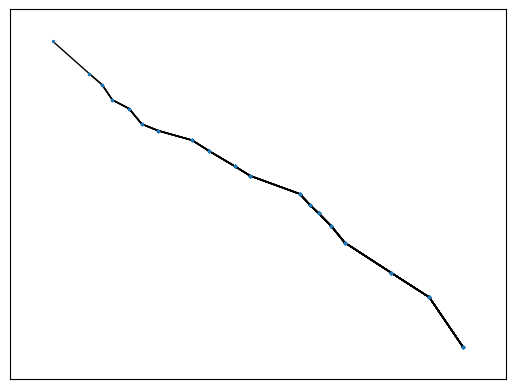

In [89]:
graph = nx.Graph(G = 0)
print(graph.graph['G'])
arbor = rar.read_arbor_full('002_1_c_day4.csv')
test_main_root = []
test_lat_tips = []
test_line_segments = {}
test_point_drawing = go.Figure()
for test_node in arbor.nodes():
    if arbor.nodes[test_node]["label"] == ("main root") or arbor.nodes[test_node]["label"] == ("main root base"):
        test_main_root.append(test_node)
    if arbor.nodes[test_node]["label"] == ("lateral root tip"):
        test_lat_tips.append(test_node)
for i in range(1, len(test_main_root)):
    test_line_segments[i] = test_main_root[i - 1], test_main_root[i]
graph_main_root(graph, test_line_segments)

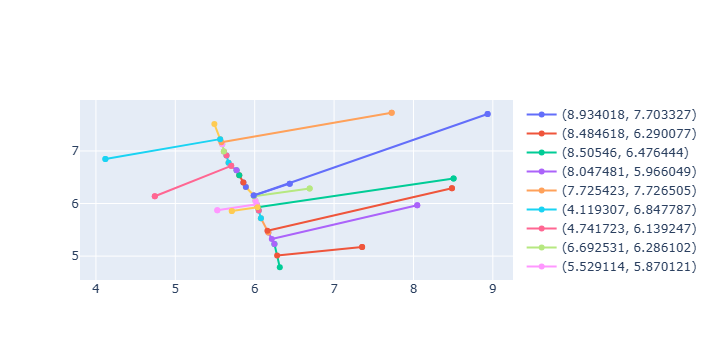

[((5.988092, 6.152656),
  (8.934018, 7.703327),
  {'b': -14.395731876449036, 'c': 56.498377083045455}),
 ((5.988092, 6.152656),
  (6.441282, 6.378145),
  {'b': -11.931814477503922, 'c': 41.74421301776141}),
 ((6.16023391, 5.48338331),
  (8.484618, 6.290077),
  {'b': -14.29779494404047, 'c': 55.612662736590764}),
 ((6.0378051500000005, 5.9277181500000005),
  (8.50546, 6.476444),
  {'b': -14.320897807986997, 'c': 55.93941765832109}),
 ((6.21581507, 5.32432581),
  (8.047481, 5.966049),
  {'b': -13.912946598794843, 'c': 53.16827196245512}),
 ((5.58006932, 7.16728952),
  (7.725423, 7.726505),
  {'b': -13.044828782228455, 'c': 48.8211647763607}),
 ((5.565074, 7.224829),
  (4.119307, 6.847787),
  {'b': -9.423590706681644, 'c': 28.697760002919644}),
 ((5.703528, 6.716372),
  (4.741723, 6.139247),
  {'b': -9.84520733210474, 'c': 30.33855603768069}),
 ((5.99128475, 6.13753615),
  (6.692531, 6.286102),
  {'b': -12.47195600743453, 'c': 44.965083024430825}),
 ((6.0247697, 5.9859266),
  (5.529114, 5

In [140]:
mygraph = nx.Graph(G = 1)
final_results = arbor_best_cost('002_1_c_day4.csv', 1, 0, 0)
graph_opt_lines(mygraph, final_results)
list(mygraph.edges(data = True))

In [26]:
def graph_opt_lines(graph, final):
    for result in final:
        x0 = result[4]
        y0 = result[5]
        p = result[6]
        q = result[7]
        first_point = x0, y0
        second_point = p, q
        G = graph.graph['Gravity']
        b, c = calc_coeff(G, x0, y0, p, q)
        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point, b = b, c = c)
    return graph

In [27]:
def get_opt_to_pq_drawings(gravity, final):
    drawings = []
    for result in final:
        if G == 0:
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            xcoords = [p, x0]
            ycoords = [q, y0]
        
            line = go.Scatter(x=xcoords, y=ycoords, name = str(result[0]))
            drawings.append(line)
        else: 
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            b, c = calc_coeff(gravity, x0, y0, p, q)
            x_opt = pylab.linspace(min(p, x0), max(p, x0))
            y_opt = gravity * x_opt ** 2 + b * x_opt + c
            line = go.Scatter(x=x_opt, y=y_opt, name = str(result[0]))
            drawings.append(line)
    return drawings
    

In [14]:
G = rar.read_arbor_full('002_1_c_day4.csv')
droot = {}
queue = []
curr = None
visited = set()

root = G.graph['main root base']

queue.append(root)
droot[root] = 0

delay = 0
while len(queue) > 0:
    curr = queue.pop(0)
    # we should never visit a node twice
    assert curr not in visited
    visited.add(curr)
    # we only measure delay for the lateral root tips
    if G.nodes[curr]['label'] == 'lateral root tip':
        delay += droot[curr]
    for u in G.neighbors(curr):
        if u not in visited:
            queue.append(u)
            droot[u] = droot[curr] + G[curr][u]['length']

# make sure we visited every node
assert len(visited) == G.number_of_nodes()
delay

29.774327793633596

In [17]:
wiring = 0
for u, v in G.edges():
    wiring += G[u][v]['length']
wiring

25.828631820795696

In [18]:
G.graph

{'arbor name': '002_1_c_day4', 'main root base': (6.316246, 4.788182)}